## Compare DE effect of single guides

In [1]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import glob
from tqdm import tqdm
import yaml

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Configure matplotlib for Illustrator-compatible PDFs
mpl.rcParams['pdf.fonttype'] = 42  # Embed fonts as TrueType
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15


sys.path.append(os.path.abspath('../'))
from utils import _convert_oak_path
from merge_DE_results import parse_DE_results_2_adata

In [2]:
import yaml

# Load color palettes from yaml file
with open('../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)

In [3]:

from DE_analysis_utils import *

In [4]:
def get_reliability(x, sigma):
    sigma2_obs = np.var(x, ddof=1)  # Observed variance across features
    sigma2_sem = np.mean(sigma**2)   # Average squared standard error
    sigma2_true = sigma2_obs - sigma2_sem  # Estimated true signal variance
    reliability = sigma2_true / (sigma2_true + sigma2_sem)
    return(reliability)

def get_max_correlation(x_a, sigma_a, x_b, sigma_b):
    """Calculate maximum possible correlation"""
    rel_a = get_reliability(x_a, sigma_a)
    rel_b = get_reliability(x_b, sigma_b)
    return np.sqrt(rel_a * rel_b)

def get_lfc_correlation(x_a, sigma_a, x_b, sigma_b):
    """Calculate maximum possible correlation"""
    corr = x_a.corr(x_b)
    corr_ceil = get_max_correlation(x_a, sigma_a, x_b, sigma_b)
    return corr, corr_ceil

In [5]:
def plot_effect_comparison(
    adata_de,
    comparison_params,
    n_top_genes=15,
    plot_correlation=False,
    axis_label='DE effect',
    corr_coords_xy=(0.01, 0.95),
    figsize=(8, 8),
    ax=None,
    annotate_genes=None
):
    """
    Scatter plot comparing DE effects on all tested genes for a pair of conditions, targets or stats.

    Parameters:
    -----------
    adata_de : AnnData
        AnnData object containing DE analysis results
    comparison_params : dict
        Dictionary with parameters for comparison (put 2 values for parameter you want to compare on x or y axis)
        - 'target_contrast_gene_name': list of target genes to analyze
        - 'stat': list of statistics to use (e.g., 'MASH_PosteriorMean')
        - 'culture_condition': list of conditions to compare
    n_top_genes : int, default=15
        Number of top/bottom genes to annotate on each axis (ignored if annotate_genes is provided)
    plot_correlation : bool, default=False
        Whether to plot correlation statistics
    ax : matplotlib.axes.Axes, optional
        Pre-existing axes for the plot. If None, a new figure and axes will be created.
    annotate_genes : list or None, optional
        List of gene names to annotate on the plot. If None, will annotate top/bottom genes as before.

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The generated figure (None if ax was provided)
    ax : matplotlib.axes.Axes
        The axes containing the plot
    pl_df : pandas.DataFrame
        The dataframe used for plotting
    """
    # Validate parameters
    compare = [k for k, v in comparison_params.items() if len(v) == 2]
    if len(compare) > 1:
        raise ValueError(f"More than one parameter has length 2: {', '.join(compare)}")
    else:
        compare = compare[0]

    # Get DE results
    res_df = get_DE_results_long(
        adata_de,
        targets=comparison_params['target_contrast_gene_name'],
        effect_estimates=comparison_params['stat'],
        gene_id_col='gene_name',
        target_id_col='target_contrast_gene_name',
        target_metadata_cols=['culture_condition']
    )
    res_df = res_df[res_df['culture_condition'].isin(comparison_params['culture_condition'])]

    # Create pivot table
    if compare != 'stat':
        pl_df = res_df.pivot(columns=compare, index='gene', values=comparison_params['stat'][0])
    else:
        pl_df = res_df[comparison_params['stat'] + ['gene']].set_index('gene')

    # Create figure if ax is not provided
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Get column names for x and y axis labels
    x_col = pl_df.columns[0]  # First column (likely 'Rest')
    y_col = pl_df.columns[1]  # Second column (likely 'Stim8hr')

    # Create scatter plot using column names from pl_df
    sns.scatterplot(data=pl_df, x=x_col, y=y_col, s=4, edgecolor='none', color='black', ax=ax)

    # Add dotted lines for x and y axes
    ax.axhline(y=0, color='gray', linestyle=':', linewidth=1)
    ax.axvline(x=0, color='gray', linestyle=':', linewidth=1)

    if plot_correlation:
        # Calculate correlation between the two conditions
        corr, pval = scipy.stats.pearsonr(pl_df[x_col], pl_df[y_col])

        # Add correlation information as text
        ax.annotate(
            f'Correlation: {corr:.3f}\n(p{" < 10e-16" if pval < 1e-16 else f" = {pval:.3e}"})',
            xy=corr_coords_xy, xycoords='axes fraction', fontsize=12
        )

    # Add axis labels and title
    ax.set_xlabel(f'{axis_label} ({x_col})', fontsize=12)
    ax.set_ylabel(f'{axis_label} ({y_col})', fontsize=12)
    ax.set_title(f'{comparison_params["target_contrast_gene_name"][0]} knock-out effect\n{x_col} vs {y_col} comparison', fontsize=14)

    # Annotate genes
    texts = []
    if annotate_genes is not None:
        # Only annotate the specified genes if they are present in pl_df
        for gene in annotate_genes:
            if gene in pl_df.index:
                row = pl_df.loc[gene]
                # Use a default color for user-specified genes
                color = 'darkgreen'
                texts.append(ax.text(row[x_col], row[y_col], gene, fontsize=8, color=color))
    else:
        # Annotate genes with extreme values (top/bottom)
        top_genes_y = pl_df.nlargest(n_top_genes, y_col)
        bottom_genes_y = pl_df.nsmallest(n_top_genes, y_col)
        top_genes_x = pl_df.nlargest(n_top_genes, x_col)
        bottom_genes_x = pl_df.nsmallest(n_top_genes, x_col)
        extreme_genes = pd.concat([top_genes_y, bottom_genes_y, top_genes_x, bottom_genes_x]).drop_duplicates()
        for idx, row in extreme_genes.iterrows():
            # Color based on which category the gene falls into
            if idx in top_genes_y.index or idx in top_genes_x.index:
                color = 'darkred'
            else:
                color = 'darkblue'
            texts.append(ax.text(row[x_col], row[y_col], idx, fontsize=8, color=color))

    # Use adjustText to avoid overlapping labels
    from adjustText import adjust_text
    adjust_text(
        texts,
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
        expand_points=(1.5, 1.5),
        force_points=(0.5, 0.5),
        ax=ax
    )

    if fig is not None:
        return fig, ax, pl_df
    else:
        return ax, pl_df

In [8]:
config = 'DE_config_by_guide.yaml'
with open(config, 'r') as config_file:
    config = yaml.safe_load(config_file)
config

{'experiment_name': 'CD4i_final',
 'datadir': '/mnt/oak/users/emma/data/GWT/',
 'run_name': 'single_guide',
 'min_replicates': 3,
 'min_cells_per_guide': 5,
 'n_hvgs': 10000,
 'min_counts_quantile': 0.005,
 'chunk_size': 50,
 'chunk_split_seed': 1423,
 'feature_selection': {'highx_min_mean_counts': 10000,
  'highx_min_pct_dropouts': 0.9,
  'lowx_min_counts': 1,
  'lowx_max_pct_dropouts': 99.9},
 'run_DE_params': {'min_counts_per_gene': 10,
  'design_formula': '~ log10_n_cells + target'},
 'file_paths': {'no_effect_guides_file': 'no_effect_guides.txt',
  'de_test_genes_file': 'DE_test_genes.txt',
  'target2chunk_file': 'DE_single_guide_target2chunk.csv.gz'}}

In [9]:
# Extract parameters from config
datadir = _convert_oak_path(config['datadir'])
experiment_name = config['experiment_name']
datadir = f'{datadir}/{experiment_name}/'
run_name = config.get('run_name', 'default')
force_combine = True

# Read cell-level metadata
sgrna_library_metadata = pd.read_csv('../../metadata/sgRNA_library_curated.csv', index_col=0)
gene_name_to_guide_id = dict(zip(sgrna_library_metadata['sgrna_id'], sgrna_library_metadata['perturbed_gene_name']))
var_df = sc.read_h5ad(f'{datadir}/{experiment_name}_merged_by_guide.DE_pseudobulk.h5ad', backed=True).var.copy()
de_results_dir = datadir + f'/DE_results_{run_name}/tmp/'

In [10]:
var_df.head()

,gene_ids,gene_name
CUSTOM001_PuroR,CUSTOM001_PuroR,PuroR
ENSG00000000003,ENSG00000000003,TSPAN6
ENSG00000000005,ENSG00000000005,TNMD
ENSG00000000419,ENSG00000000419,DPM1
ENSG00000000457,ENSG00000000457,SCYL3


In [11]:
de_results_files = glob.glob(de_results_dir + 'DE_results_by_guide.*.csv.gz')

In [15]:
de_results_adatas = []

for file in tqdm(de_results_files, desc="Processing DE result files"):
    # try:
    df = pd.read_csv(file, compression='gzip', index_col=0)
    df = df.rename({'contrast': 'target_contrast'}, axis=1)
    df['target_contrast_gene_name'] = df['target_contrast'].map(lambda x: gene_name_to_guide_id.get(x, x))
    de_results_adatas.append(parse_DE_results_2_adata(df))
    # except EOFError:
    #     continue

combined_de_adata = anndata.concat(de_results_adatas, label='chunk')
# combined_de_adata.obs_names = combined_de_adata.obs_names.str.split('-').str[0]
assert combined_de_adata.obs_names.is_unique

Processing DE result files: 100%|██████████| 131/131 [03:22<00:00,  1.54s/it]


In [16]:
# Add gene names
combined_de_adata.var = var_df.loc[combined_de_adata.var_names]
combined_de_adata.layers['zscore'] = combined_de_adata.layers['log_fc'] / combined_de_adata.layers['lfcSE']
combined_de_adata.obs['n_cells_target'] = 1

In [17]:
de_counts = get_de_stats(combined_de_adata, effect_col='zscore', signif_col='adj_p_value', alpha=0.1)
de_counts.head()

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes
ADAT3-2_Stim8hr,ADAT3-2,ADAT3,Stim8hr,1,45,12,57
AP1S2-2_Stim8hr,AP1S2-2,AP1S2,Stim8hr,1,67,21,88
ARPC2-2_Stim8hr,ARPC2-2,ARPC2,Stim8hr,1,272,81,353
ARPC3-2_Stim8hr,ARPC3-2,ARPC3,Stim8hr,1,71,22,93
BCAP29-2_Stim8hr,BCAP29-2,BCAP29,Stim8hr,1,0,1,1


In [19]:
de_counts.value_counts(['condition'])

condition
Stim8hr      2350
Stim48hr     2118
Rest         2040
Name: count, dtype: int64

In [23]:
combined_de_adata.write_h5ad(datadir + f'/DE_results_{run_name}/{experiment_name}.merged_DE_results_by_guide.h5ad')

In [24]:
print(datadir + f'/DE_results_{run_name}/{experiment_name}.merged_DE_results_by_guide.h5ad')

/mnt/oak/users/emma/data/GWT//CD4i_final//DE_results_single_guide/CD4i_final.merged_DE_results_by_guide.h5ad


## Assess correlation between guides

In [68]:
all_conditions = ['Rest', 'Stim8hr', 'Stim48hr']
correlations_all = []

for c in all_conditions:
    guide_counts = combined_de_adata.obs[combined_de_adata.obs.culture_condition == c].target_contrast_gene_name.value_counts()
    test_targets = guide_counts[guide_counts == 2].index.tolist()

    cond_de_counts = de_counts[de_counts['condition'] == c]
    test_targets = cond_de_counts[cond_de_counts.target_name.isin(test_targets) & (cond_de_counts['n_total_de_genes'] > 2)].sort_values(['target_name']).target_name.unique()
    len(test_targets)
    lfc_df = sc.get.obs_df(
        combined_de_adata[combined_de_adata.obs.culture_condition == c], combined_de_adata.var_names.tolist() + ['target_contrast_gene_name'], layer='log_fc')
    lfcse_df = sc.get.obs_df(
        combined_de_adata[combined_de_adata.obs.culture_condition == c], combined_de_adata.var_names.tolist() + ['target_contrast_gene_name'], layer='lfcSE')
    fdr_df = sc.get.obs_df(
        combined_de_adata[combined_de_adata.obs.culture_condition == c], combined_de_adata.var_names.tolist() + ['target_contrast_gene_name'], layer='adj_p_value')
    correlations = []
    for t in tqdm(test_targets, desc="Calculating guide correlations"):
        lfc_pair = lfc_df[lfc_df['target_contrast_gene_name'] == t].T.drop('target_contrast_gene_name')
        lfcse_pair = lfcse_df[lfcse_df['target_contrast_gene_name'] == t].T.drop('target_contrast_gene_name')
        fdr_pair = fdr_df[fdr_df['target_contrast_gene_name'] == t].T.drop('target_contrast_gene_name')

        # Get mask for genes with p < 0.1 in either test
        sig_mask = (fdr_pair.iloc[:,0] < 0.1) | (fdr_pair.iloc[:,1] < 0.1)

        # Filter data using mask
        data1 = lfc_pair.iloc[:,0][sig_mask]
        data2 = lfc_pair.iloc[:,1][sig_mask]
        se1 = lfcse_pair.iloc[:,0][sig_mask] 
        se2 = lfcse_pair.iloc[:,1][sig_mask]

        # Calculate correlation and ceiling
        corr, corr_ceil = get_lfc_correlation(data1, se1, data2, se2)

        correlations.append({
            'target': t,
            'correlation': corr,
            'correlation_ceiling': corr_ceil,
            'n_signif': data1.shape[0],
            'pvalue': pval,
            'culture_condition': c
        })
    correlations_all.extend(correlations)

correlations_df = pd.DataFrame(correlations_all)

Calculating guide correlations:   0%|          | 0/516 [00:00<?, ?it/s]/tmp/ipykernel_3017337/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/tmp/ipykernel_3017337/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
Calculating guide correlations:   5%|▍         | 25/516 [00:00<00:04, 121.48it/s]/tmp/ipykernel_3017337/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/tmp/ipykernel_3017337/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/tmp/ipykernel_3017337/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
Calculating guide correlations:  10%|▉         | 51/516 [00:00<00:03, 121.92it/s]/tmp/ipykernel_3017337/3615270918.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/tmp/ipykernel_3017337/361527

In [69]:
correlations_df.head()

,target,correlation,correlation_ceiling,n_signif,pvalue,culture_condition
0,A2M,-0.464687,NaN,10,0.002901,Rest
1,ABCC1,0.105631,NaN,80,0.002901,Rest
2,ABHD12,0.493164,0.626067,370,0.002901,Rest
3,ABHD13,-0.331309,0.540414,499,0.002901,Rest
4,ABHD14A,0.958822,0.943267,5,0.002901,Rest


In [73]:
correlations_df.to_csv("./results/DE_by_guide.correlation_results.csv")

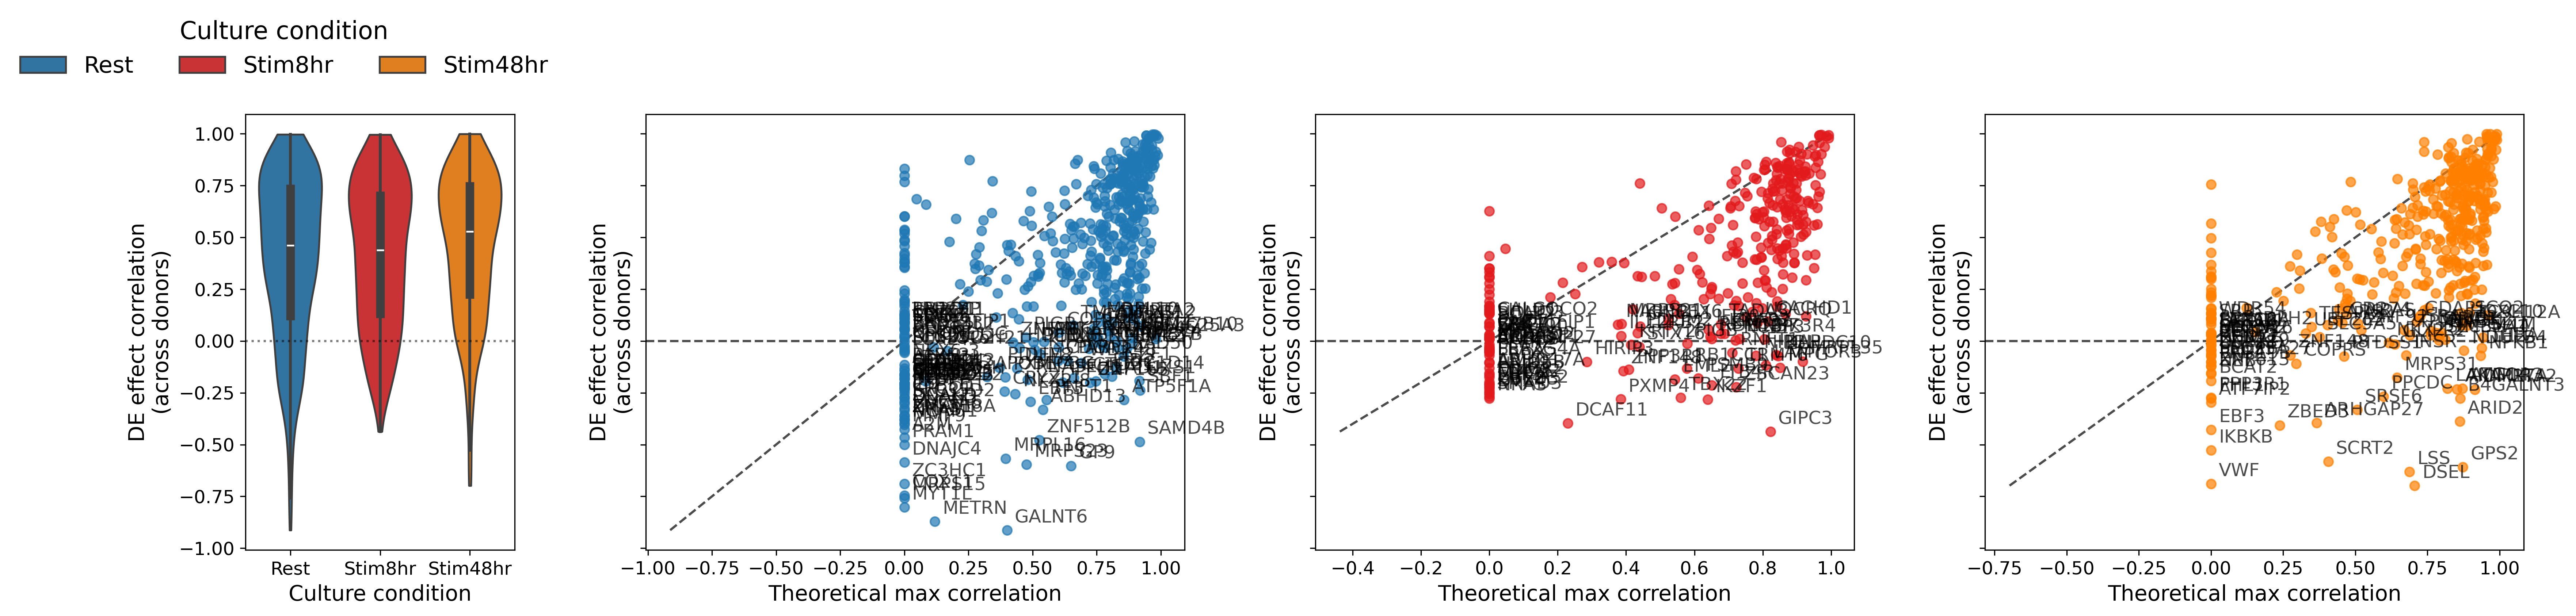

In [70]:
# Calculate mean and standard error per target and condition
summary_stats = correlations_df.groupby(['target', 'culture_condition']).agg({
    'correlation': ['mean', 'std', 'count'],
    'correlation_ceiling': ['mean', 'std']
}).reset_index()

# Fill NAs in correlation_ceiling with 0
summary_stats[('correlation_ceiling', 'mean')] = summary_stats[('correlation_ceiling', 'mean')].fillna(0)
summary_stats[('correlation_ceiling', 'std')] = summary_stats[('correlation_ceiling', 'std')].fillna(0)

# Calculate standard errors
summary_stats['correlation_se'] = summary_stats[('correlation', 'std')] / np.sqrt(summary_stats[('correlation', 'count')])
summary_stats['correlation_ceiling_se'] = summary_stats[('correlation_ceiling', 'std')] / np.sqrt(summary_stats[('correlation', 'count')])

# Create figure with subplots for each condition plus boxplot
conditions = ['Rest', 'Stim8hr', 'Stim48hr']
ylabel = 'DE effect correlation\n(across donors)'
correlations_df['culture_condition'] = correlations_df['culture_condition'].astype('category').cat.reorder_categories(conditions)
fig, axes = plt.subplots(1, len(conditions) + 1, figsize=(6*(len(conditions) + 1), 6), sharey=True, gridspec_kw={'width_ratios': [1, 2, 2, 2]})

# Add violinplot in the first subplot with reduced width
sns.violinplot(data=correlations_df.reset_index(), x='culture_condition', y='correlation', hue='culture_condition', ax=axes[0],
            order=conditions, palette=palettes['culture_condition'], density_norm='width', cut=0, width=0.7,
            legend=True)
axes[0].legend(title='Culture condition', bbox_to_anchor=(1.2, 1.15), loc='right', ncol=3, frameon=False)
axes[0].set_xlabel('Culture condition', fontsize=14)
axes[0].set_ylabel(ylabel, fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].axhline(y=0, color='black', linestyle=':', alpha=0.5)  # Add dotted line at y=0

for i, condition in enumerate(conditions):
    condition_stats = summary_stats[summary_stats['culture_condition'] == condition]
    
    # Get axis limits for this condition
    min_val = min(condition_stats[('correlation_ceiling', 'mean')].min(), condition_stats[('correlation', 'mean')].min())
    max_val = max(condition_stats[('correlation_ceiling', 'mean')].max(), condition_stats[('correlation', 'mean')].max())
    
    # Add diagonal line
    axes[i+1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7)
    axes[i+1].axhline(0, color='black', linestyle='--', alpha=0.7)
    
    # Plot error bars
    axes[i+1].errorbar(x=condition_stats[('correlation_ceiling', 'mean')],
                    y=condition_stats[('correlation', 'mean')],
                    xerr=condition_stats['correlation_ceiling_se'],
                    yerr=condition_stats['correlation_se'],
                    fmt='o',
                    color=palettes['culture_condition'][condition],
                    alpha=0.7)
    
    # Add labels with increased font size
    axes[i+1].set_xlabel('Theoretical max correlation', fontsize=14)
    axes[i+1].set_ylabel(ylabel, fontsize=14)
    axes[i+1].tick_params(axis='both', labelsize=12)
    
    # Add target names as annotations only for genes with mean correlation < 0.1
    for j, target in enumerate(condition_stats['target']):
        if condition_stats[('correlation', 'mean')].iloc[j] < 0.1:
            axes[i+1].annotate(target,
                           (condition_stats[('correlation_ceiling', 'mean')].iloc[j],
                            condition_stats[('correlation', 'mean')].iloc[j]),
                           xytext=(5, 5), textcoords='offset points',
                           alpha=0.7,
                           fontsize=12)

plt.tight_layout(w_pad=0.5)
# plt.savefig('../results/donor_robustness_figure.pdf')
# plt.savefig('../results/donor_robustness_figure.png')

<Axes: >

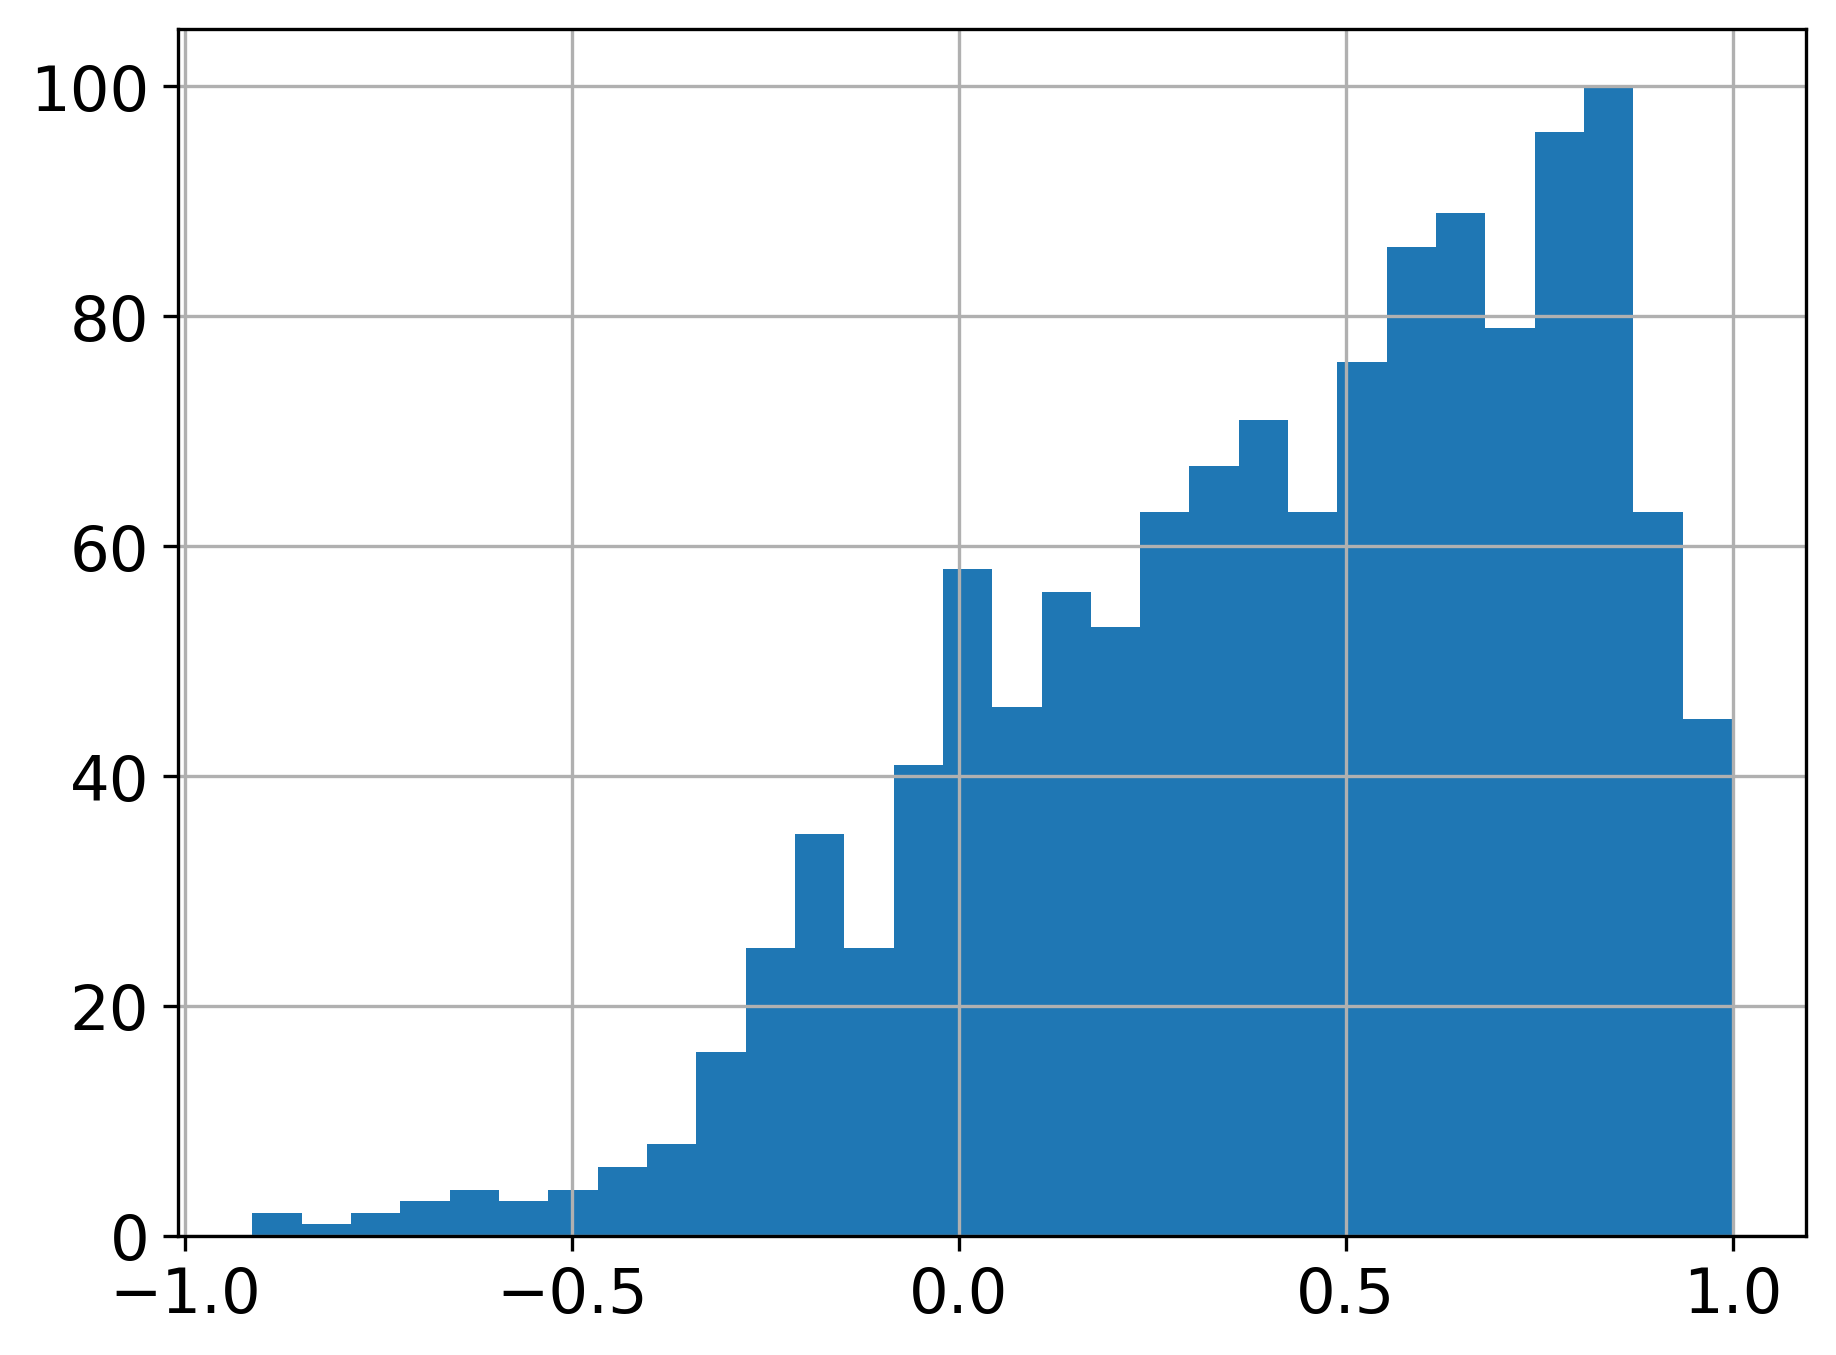

In [71]:
correlations_df['correlation'].hist(bins=30)

<Axes: xlabel='correlation_ceiling', ylabel='correlation'>

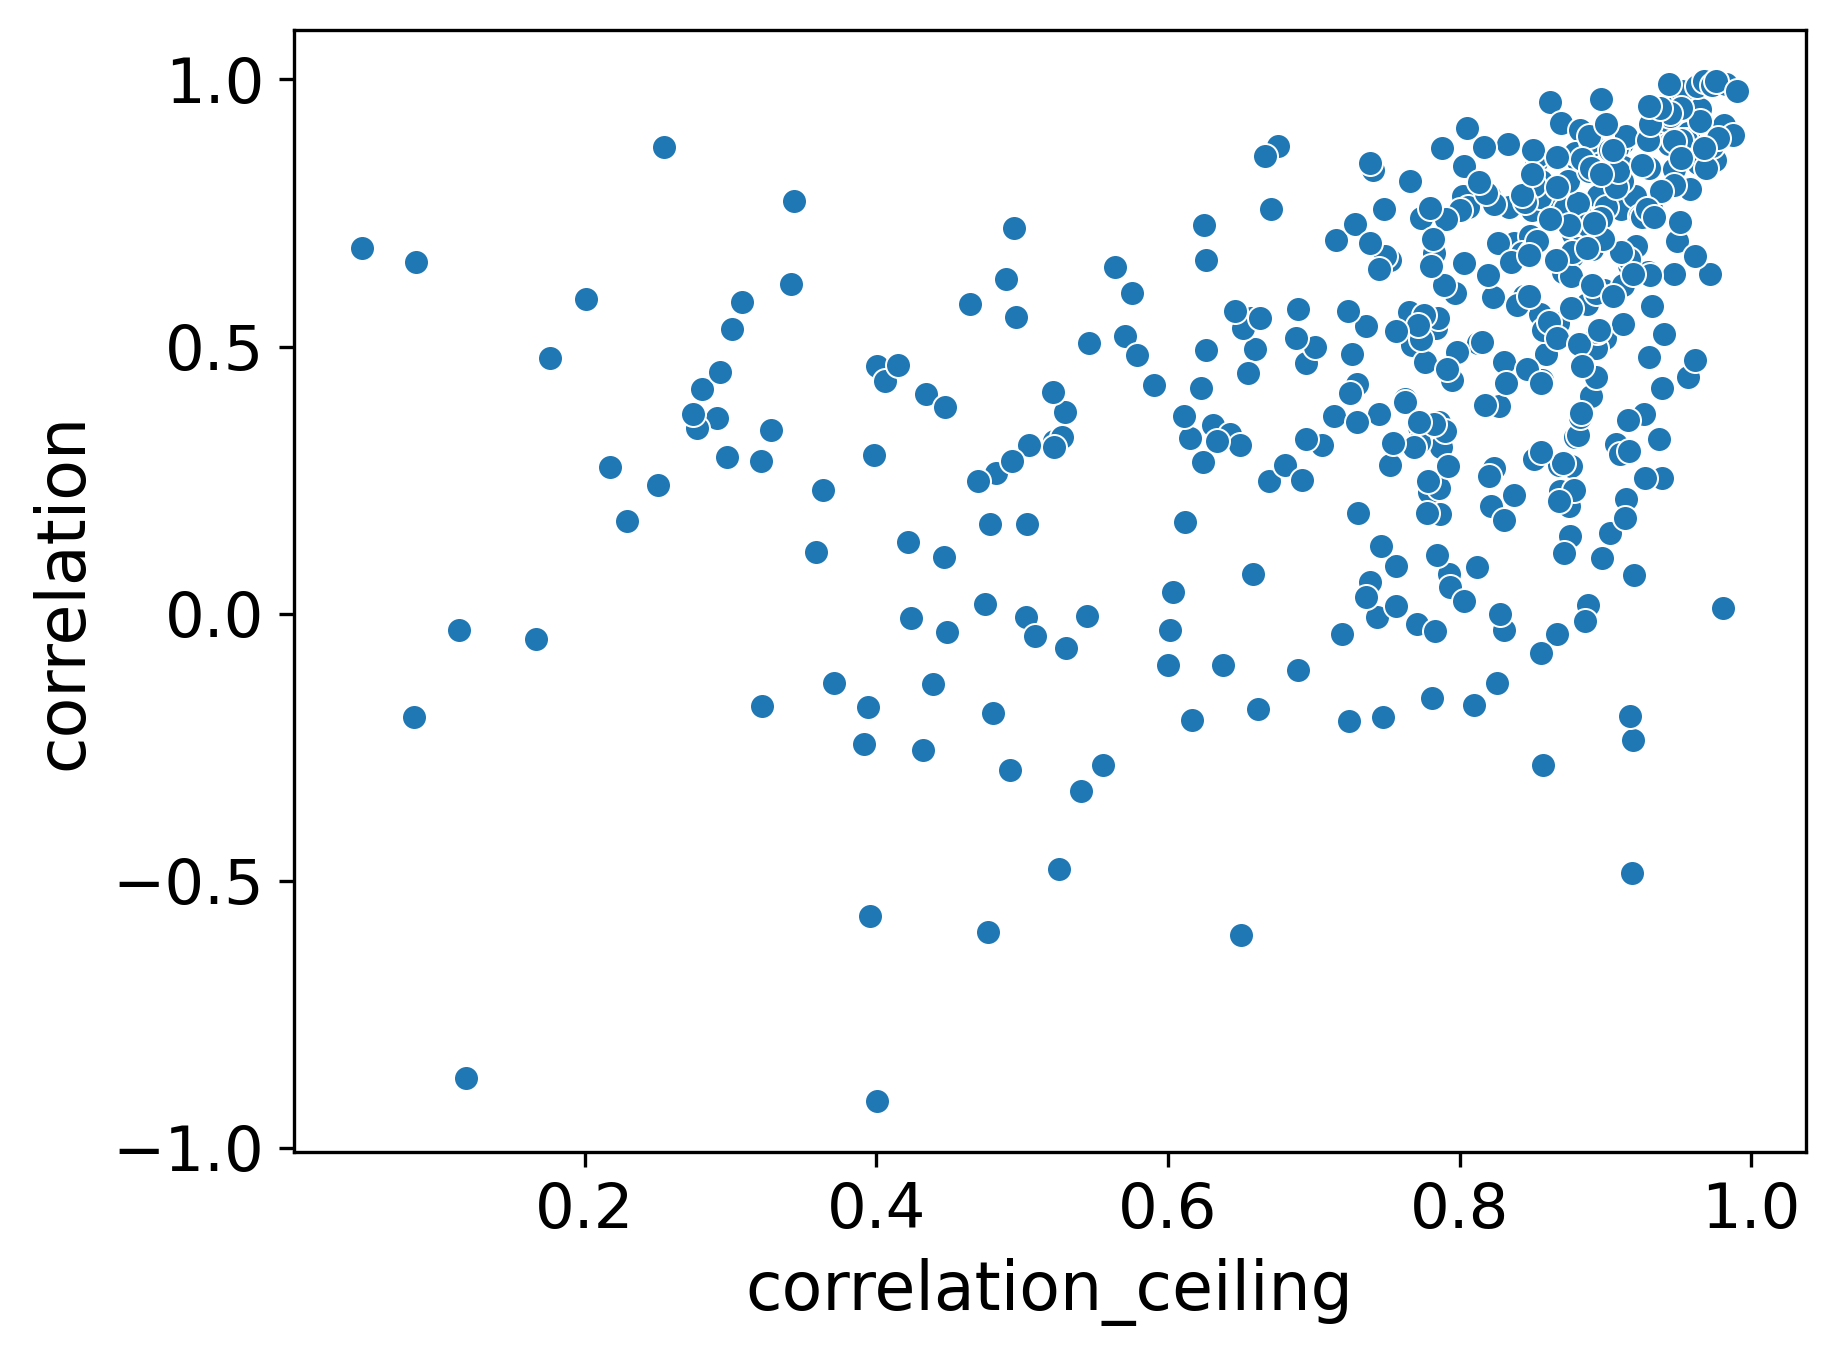

In [56]:
sns.scatterplot(data=correlations_df, x='correlation_ceiling', y='correlation')

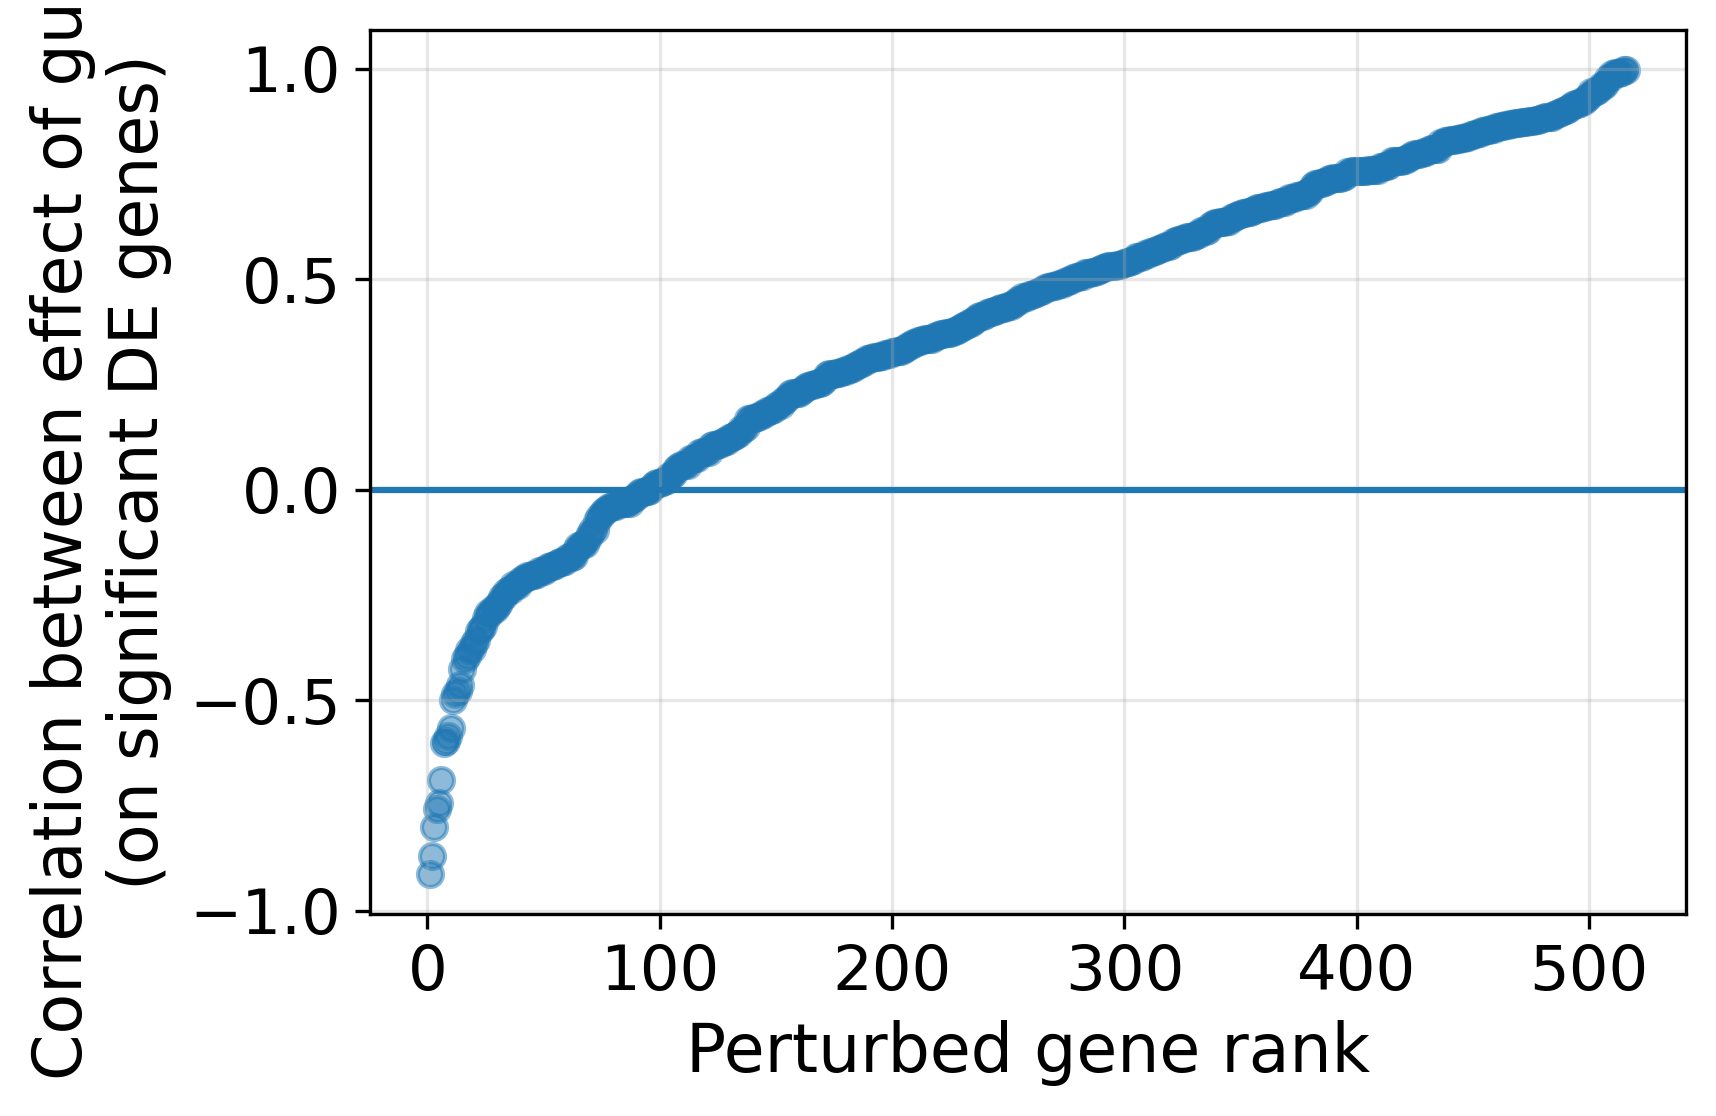

In [53]:
correlations_df = pd.DataFrame(correlations)
correlations_df['pvalue'] = np.where(correlations_df['pvalue'] < 1e-100, 1e-100, correlations_df['pvalue'])
plt.figure(figsize=(6,4))
plt.scatter(correlations_df['correlation'].rank(), correlations_df['correlation'], alpha=0.5)
plt.xlabel('Perturbed gene rank')
plt.ylabel('Correlation between effect of guides\n(on significant DE genes)')
plt.axhline(0)
plt.grid(True, alpha=0.3)

In [393]:
correlations_df[correlations_df.pvalue < 0.05].sort_values(['correlation'])

,target,correlation,pvalue
266,SURF1,-0.343383,8.489798e-18
296,TTC9,-0.215109,7.001038e-04
176,NDUFA11,-0.157771,2.960956e-04
147,KIFAP3,-0.059159,2.336240e-02
60,CHD7,0.138906,1.772742e-08
...,...,...,...
91,DYRK2,0.999197,2.552018e-02
289,TRAF5,0.999421,2.166194e-02
265,STX10,0.999768,1.371426e-02
172,MTMR14,0.999991,2.748676e-03


<Axes: xlabel='n_nearby_genes', ylabel='correlation'>

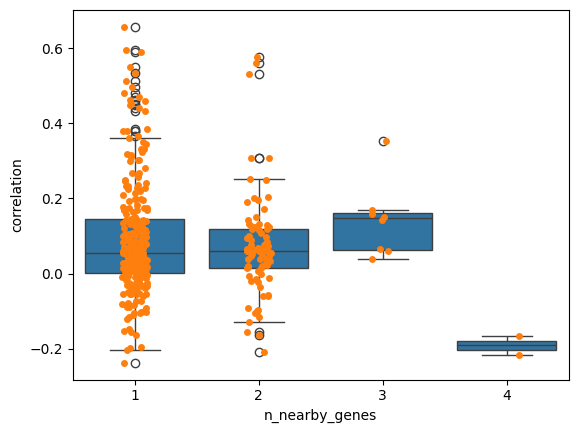

In [304]:
guide_annotation_deep = pd.read_csv('../5_sgRNA_annotation/results/sgrna_df_final.csv', index_col=0)
guide_annotation_deep['n_nearby_genes'] = guide_annotation_deep['nearby_gene_within_2kb'].apply(lambda x: len(eval(x)))
n_nearby_genes = guide_annotation_deep[['target_gene_name_from_sgRNA', 'n_nearby_genes']].drop_duplicates().rename({'target_gene_name_from_sgRNA':'target'}, axis=1)
pl_df = pd.merge(correlations_df, n_nearby_genes)
sns.boxplot(data=pl_df, y='correlation', x='n_nearby_genes')
sns.stripplot(data=pl_df, y='correlation', x='n_nearby_genes')

/tmp/ipykernel_1540039/3493358340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_counts_cond['guide_id'] = de_counts_cond['target_contrast'].str.split('-').str[1]


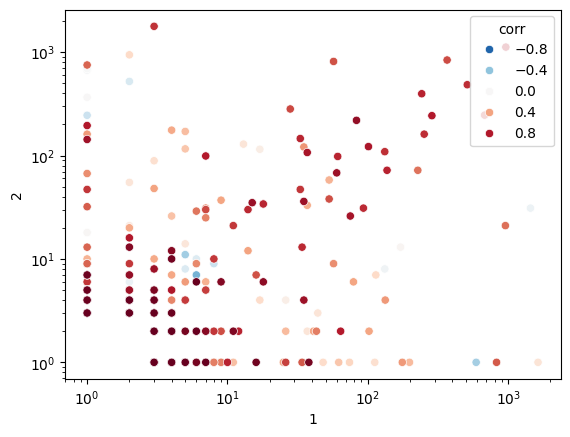

In [362]:
de_counts_cond = de_counts[(de_counts['condition'] == c) & (de_counts.target_name.isin(correlations_df.target))]
de_counts_cond['guide_id'] = de_counts_cond['target_contrast'].str.split('-').str[1]
de_counts_cond = de_counts_cond.pivot_table(index='target_name', columns='guide_id', values='n_total_de_genes', aggfunc='first')
de_counts_cond['corr'] = correlations_df.set_index('target').loc[de_counts_cond.index]['correlation']
# Get min/max correlation values and take the larger absolute value for symmetric limits
vmax = max(abs(de_counts_cond['corr'].min()), abs(de_counts_cond['corr'].max()))

# Sort by absolute correlation value so high correlations plot on top
plot_df = de_counts_cond.copy()
plot_df['abs_corr'] = abs(plot_df['corr'])
plot_df = plot_df.sort_values('corr')

sns.scatterplot(
    x=plot_df['1'],
    y=plot_df['2'],
    hue=plot_df['corr'],
    palette=sns.color_palette('RdBu_r', as_cmap=True),
    hue_norm=(-vmax, vmax)
)
# plt.colorbar(label='Correlation')
plt.xscale('log'); plt.yscale('log')

In [282]:
plot_df['diff'] = plot_df['1'] / (plot_df['1']+plot_df['2'])

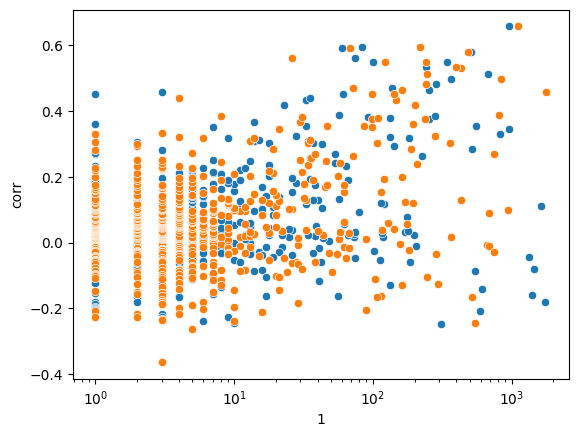

In [287]:
sns.scatterplot(data=plot_df, x='1', y='corr');
sns.scatterplot(data=plot_df, x='2', y='corr');
plt.xscale('log')

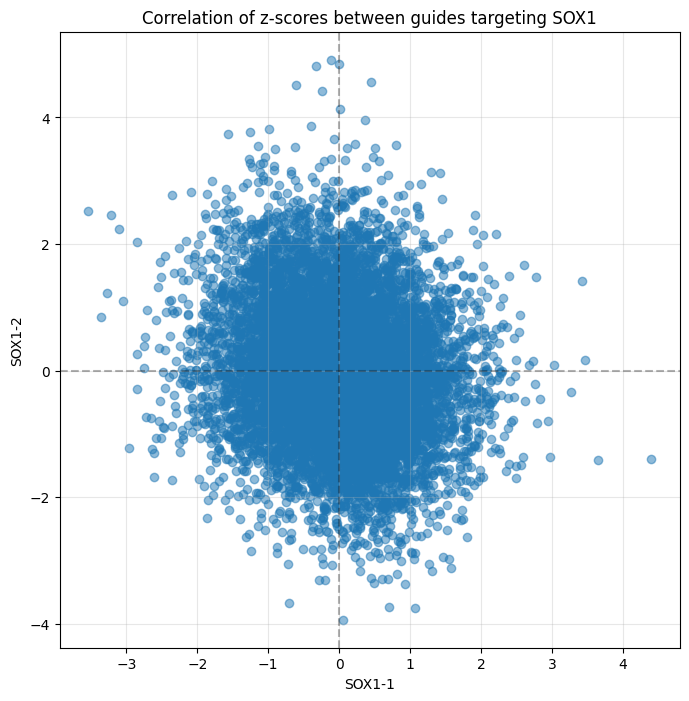

In [367]:
t = 'SOX1'
guide_pair_effect = get_DE_results_long(
    combined_de_adata,
    targets=[f'{t}-1', f'{t}-2', f'{t}-3'],
    effect_estimates = ['zscore'],
    signif_estimate = 'adj_p_value', 
    target_id_col = 'target_contrast',
    gene_id_col='gene_name'
)
guide_pair_effect = guide_pair_effect[guide_pair_effect['culture_condition'] == c]

pivoted = guide_pair_effect.pivot(columns='target_contrast', index='gene', values='zscore')
# Pivot the data and create scatter plot

plt.figure(figsize=(8,8))
plt.scatter(pivoted.iloc[:,0], pivoted.iloc[:,1], alpha=0.5)
plt.xlabel(pivoted.columns[0])
plt.ylabel(pivoted.columns[1])
plt.title(f'Correlation of z-scores between guides targeting {t}')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.grid(True, alpha=0.3)

In [376]:
combined_de_adata.obs['perturbed_gene_name'] = combined_de_adata.obs['target_contrast_gene_name'].copy()
combined_de_adata.obs['target_contrast_gene_name'] = combined_de_adata.obs['target_contrast'].copy()

In [382]:
combined_de_adata.var_names = combined_de_adata.var['gene_name'].values

In [397]:
res_df = get_DE_results_long(
    combined_de_adata,
    targets=[f'{t}-1', f'{t}-2'],
    effect_estimates='zscore',
    gene_id_col='gene_name',
    target_id_col='target_contrast_gene_name',
    target_metadata_cols=['culture_condition']
    )
signif_gs = res_df[res_df.significant].gene_name.tolist()

ValueError: too many values to unpack (expected 2)

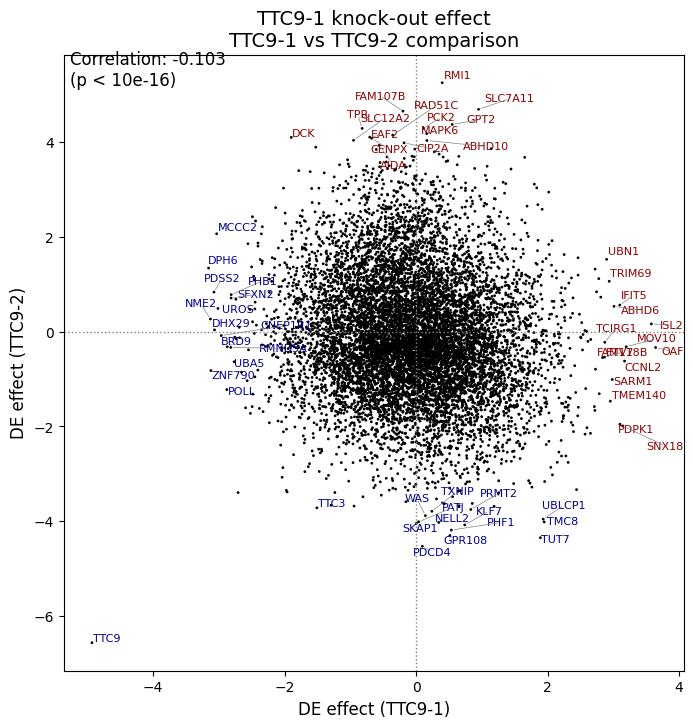

In [411]:
t = 'TTC9'
_, res = plot_effect_comparison(
        combined_de_adata, 
        comparison_params = {
            'target_contrast_gene_name':[f'{t}-1', f'{t}-2'],
            'culture_condition':['Rest'],
            'stat':['zscore']
        },
        plot_correlation = True,
        annotate_genes = None, figsize=(8,8)
        )

In [322]:
guide_pair_effect[guide_pair_effect.gene == 'ENSG00000004766']

,index,gene,zscore,adj_p_value,significant,gene_name,culture_condition,target_contrast
132,VPS50-1_Rest,ENSG00000004766,-6.610825,4.702779e-07,True,VPS50,Rest,VPS50-1
134,VPS50-2_Rest,ENSG00000004766,-4.185729,7.382253e-02,True,VPS50,Rest,VPS50-2


In [320]:
guide_annotation_deep = pd.read_csv('../5_sgRNA_annotation/results/sgrna_df_final.csv', index_col=0)
guide_annotation_deep[guide_annotation_deep.target_gene_name_from_sgRNA == t]

,sgRNA,chromosome,pos,seq_last19bp,strand,PAM,note,flag,seq,target_gene_name_from_sgRNA,...,nearby_gene_within_30kb,nearest_within2kb_gene_id,nearest_within2kb_gene_name,nearest_within2kb_gene_dist,nearest_within2kb_nontarget_gene_id,nearest_within2kb_nontarget_gene_name,nearest_within2kb_nontarget_gene_dist,putative_bidirectional_promoter,other_alignment_chromosome,other_alignment_pos
7749,VPS50-1,chr7,93232375,GACACTAGGAAGCCATAGT,-,True,"unique alignment, aligned to target gene",False,GGACACTAGGAAGCCATAGT,VPS50,...,"['ENSG00000188175', 'ENSG00000004766']",ENSG00000004766,VPS50,6.0,NaN,NaN,NaN,False,NaN,NaN
19722,VPS50-2,chr7,93232360,TCCACGTGACCACCCACTA,+,True,"unique alignment, aligned to target gene",False,GTCCACGTGACCACCCACTA,VPS50,...,"['ENSG00000188175', 'ENSG00000004766']",ENSG00000004766,VPS50,6.0,NaN,NaN,NaN,False,NaN,NaN
